In [7]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# PyTorch kütüphanesi
import torch
import torch.nn as nn
import torch.optim as optim

# Uyarıları filtrele
warnings.filterwarnings('ignore')
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Cihaz seçimi (GPU varsa kullan)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sadek çalışma ortamı hazır. Kullanılan cihaz: {device}")

Sadek çalışma ortamı hazır. Kullanılan cihaz: cpu


In [8]:
# 1. Veri Yükleme
try:
    df = pd.read_csv('owid-energy-data.csv')
except FileNotFoundError:
    print("HATA: 'owid-energy-data.csv' dosyası bulunamadı.")
    raise

# 2. Filtreleme (2022 Yılı ve Ülkeler)
df_clean = df[(df['year'] == 2022) & (~df['iso_code'].str.contains('OWID', na=True))].dropna(subset=['iso_code'])

# 3. Özellik ve Hedef Değişken Seçimi
target_col = 'carbon_intensity_elec'
feature_cols = [
    'biofuel_share_elec', 'coal_share_elec', 'solar_share_elec',
    'hydro_share_elec', 'nuclear_share_elec', 'oil_share_elec',
    'gas_share_elec', 'wind_share_elec',
    'gdp', 'population', 'energy_per_capita'
]

data = df_clean[feature_cols + [target_col]].copy()

# 4. Eksik Veri Doldurma (Median Imputation)
for col in data.columns:
    data[col] = data[col].fillna(data[col].median())

# 5. Veri Ayrımı (X ve y)
X = data[feature_cols].values
y = data[target_col].values.reshape(-1, 1)

# 6. Eğitim ve Test Ayrımı (%80 Train, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Ölçeklendirme (Scaling)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 8. PyTorch Tensor Dönüşümü
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print(f"Veri hazırlandı. Eğitim seti: {X_train.shape}, Test seti: {X_test.shape}")

Veri hazırlandı. Eğitim seti: (176, 11), Test seti: (44, 11)


In [9]:
# Model 3 - Batch Normalization Ağı
# Mimari: Linear -> Batch Norm -> ReLU ...
# Optimizer: SGD (Stochastic Gradient Descent) + Momentum

class BatchNormNN(nn.Module):
    def __init__(self, input_dim):
        super(BatchNormNN, self).__init__()
        # Katman 1
        self.layer1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64) # Batch Normalization (Eğitimi hızlandırır ve stabilize eder)
        
        # Katman 2
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        # Çıkış Katmanı
        self.output = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x))) # BN, aktivasyondan önce uygulanır
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.output(x)
        return x

# Model Kurulumu
input_dim = X_train.shape[1]
model_sadek_1 = BatchNormNN(input_dim).to(device)
criterion = nn.MSELoss()

# FARKLI OPTIMIZER: SGD kullanıyoruz 
optimizer = optim.SGD(model_sadek_1.parameters(), lr=0.01, momentum=0.9)

# Eğitim Döngüsü
print("Model 3 (Sadek - BN/SGD) Eğitiliyor...")
loss_history_s1 = []
epochs = 500

for epoch in range(epochs):
    model_sadek_1.train()
    optimizer.zero_grad()
    outputs = model_sadek_1(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history_s1.append(loss.item())

# Değerlendirme
model_sadek_1.eval()
with torch.no_grad():
    pred_scaled = model_sadek_1(X_test_tensor).cpu().numpy()
    pred_s1 = scaler_y.inverse_transform(pred_scaled)

rmse_s1 = np.sqrt(mean_squared_error(y_test, pred_s1))
r2_s1 = r2_score(y_test, pred_s1)
print(f"Model 3 Sonuç -> RMSE: {rmse_s1:.4f}, R2: {r2_s1:.4f}")

Model 3 (Sadek - BN/SGD) Eğitiliyor...
Model 3 Sonuç -> RMSE: 161.6178, R2: 0.5055


In [10]:
# Model 4 - ELU Aktivasyonu ve RMSprop
# Mimari: ReLU yerine ELU (Exponential Linear Unit) kullanılır.
# Optimizer: RMSprop 

class EluNN(nn.Module):
    def __init__(self, input_dim):
        super(EluNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128) # Daha geniş bir ilk katman
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
        self.elu = nn.ELU() # ELU aktivasyonu negatif değerlere de izin verir

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        x = self.elu(self.layer3(x))
        x = self.output(x)
        return x

# Model Kurulumu
model_sadek_2 = EluNN(input_dim).to(device)

# FARKLI OPTIMIZER: RMSprop
optimizer = optim.RMSprop(model_sadek_2.parameters(), lr=0.001)

# Eğitim Döngüsü
print("Model 4 (Sadek - ELU/RMSprop) Eğitiliyor...")
loss_history_s2 = []
epochs = 800 # RMSprop genelde daha yavaş yakınsayabilir, epoch artırdık

for epoch in range(epochs):
    model_sadek_2.train()
    optimizer.zero_grad()
    outputs = model_sadek_2(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history_s2.append(loss.item())

# Değerlendirme
model_sadek_2.eval()
with torch.no_grad():
    pred_scaled = model_sadek_2(X_test_tensor).cpu().numpy()
    pred_s2 = scaler_y.inverse_transform(pred_scaled)

rmse_s2 = np.sqrt(mean_squared_error(y_test, pred_s2))
r2_s2 = r2_score(y_test, pred_s2)
print(f"Model 4 Sonuç -> RMSE: {rmse_s2:.4f}, R2: {r2_s2:.4f}")

Model 4 (Sadek - ELU/RMSprop) Eğitiliyor...
Model 4 Sonuç -> RMSE: 90.1217, R2: 0.8462


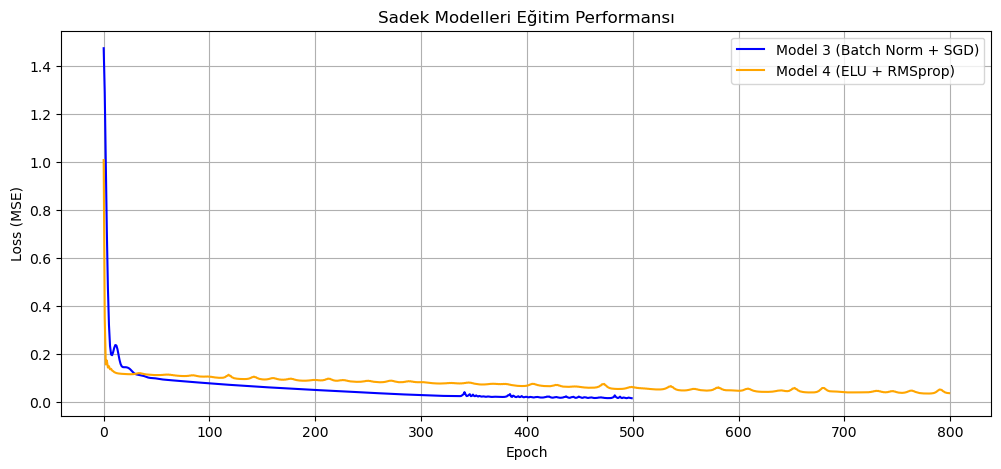


--- FİNAL SONUÇLARI ---
                   Model        RMSE  R2 Score Optimizer              Özellik
0  Model 3 (BN/SGD)       161.617840  0.505457       SGD  Batch Normalization
1  Model 4 (ELU/RMSprop)   90.121679  0.846226   RMSprop       ELU Activation


In [15]:
# Modellerinin Karşılaştırması

# 1. Kayıp Grafikleri (Loss Curves)
plt.figure(figsize=(12, 5))
plt.plot(loss_history_s1, label='Model 3 (Batch Norm + SGD)', color='blue')
plt.plot(loss_history_s2, label='Model 4 (ELU + RMSprop)', color='orange')
plt.title('Sadek Modelleri Eğitim Performansı')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Sonuç Tablosu
results_df = pd.DataFrame({
    'Model': ['Model 3 (BN/SGD)     ', 'Model 4 (ELU/RMSprop)'],
    'RMSE': [rmse_s1, rmse_s2],
    'R2 Score': [r2_s1, r2_s2],
    'Optimizer': ['SGD', 'RMSprop'],
    'Özellik': ['Batch Normalization', 'ELU Activation']
})

print("\n--- FİNAL SONUÇLARI ---")
print(results_df)

In [12]:
# Modellerin Kaydedilmesi

if not os.path.exists('final_models_sadek'):
    os.makedirs('final_models_sadek')

# Modelleri kaydet
torch.save(model_sadek_1.state_dict(), 'final_models_sadek/sadek_model1.pth')
torch.save(model_sadek_2.state_dict(), 'final_models_sadek/sadek_model2.pth')

# Scaler'ları ve sonuçları da kaydedelim
joblib.dump(scaler_X, 'final_models_sadek/scaler_X.pkl')
joblib.dump(scaler_y, 'final_models_sadek/scaler_y.pkl')
results_df.to_csv('final_models_sadek/sadek_results.csv', index=False)

print("Sadek modelleri 'final_models_sadek' klasörüne başarıyla kaydedildi.")

Sadek modelleri 'final_models_sadek' klasörüne başarıyla kaydedildi.
